# RNNによるfxデータ予測

In [3]:
import tensorflow
from tensorflow.keras import  models, layers
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('./module')
from utils import cum_std, log_diff, log_diff_inv, load_fx_data

np.random.seed(0)

# データ読み込み

In [4]:
instrument_list = ['USD_JPY', 'GBP_JPY', 'EUR_JPY']

df_dict_train = load_fx_data(instrument_list, data_kind='train')
df_dict_test = load_fx_data(instrument_list, data_kind='test')

df_dict_train['EUR_JPY']

,Open_ask,High_ask,Low_ask,Close_ask,Volume,Open_bid,High_bid,Low_bid,Close_bid
Time,,,,,,,,,
2014-01-01 22:00:00+00:00,144.926,145.163,142.859,143.366,143014,144.776,145.108,142.838,143.228
2014-01-02 22:00:00+00:00,143.387,143.387,141.975,142.527,113868,143.237,143.306,141.951,142.412
2014-01-05 22:00:00+00:00,142.515,142.793,141.512,142.080,125100,142.464,142.775,141.491,142.007
2014-01-06 22:00:00+00:00,142.080,142.600,141.951,142.449,115303,142.006,142.584,141.930,142.377
2014-01-07 22:00:00+00:00,142.449,143.184,142.130,142.405,128572,142.380,143.161,142.109,142.316
...,...,...,...,...,...,...,...,...,...
2018-12-03 22:00:00+00:00,129.037,129.065,127.632,127.951,26900,128.927,129.019,127.613,127.901
2018-12-04 22:00:00+00:00,127.989,128.502,127.801,128.439,16113,127.939,128.483,127.782,128.389
2018-12-05 22:00:00+00:00,128.433,128.468,127.683,128.214,37536,128.383,128.418,127.663,128.164


In [5]:
df_dict_log_train = {}
for instrument in df_dict_train.keys():
    df_stable = df_dict_train[instrument].copy()
    for column in df_stable.columns:
        df_stable[column] = log_diff(df_stable[column].values)
    df_dict_log_train[instrument] = df_stable

df_dict_log_test = {}
for instrument in df_dict_test.keys():
    df_stable = df_dict_test[instrument].copy()
    for column in df_stable.columns:
        df_stable[column] = log_diff(df_stable[column].values)
    df_dict_log_test[instrument] = df_stable
df_dict_log_test['USD_JPY']

,Open_ask,High_ask,Low_ask,Close_ask,Volume,Open_bid,High_bid,Low_bid,Close_bid
Time,,,,,,,,,
2019-01-01 22:00:00+00:00,4.697202,4.698077,4.688748,4.690770,10.333840,4.696290,4.697913,4.688610,4.689851
2019-01-02 22:00:00+00:00,-0.006983,-0.007051,-0.036036,-0.011504,0.714029,-0.006365,-0.007722,-0.036852,-0.011115
2019-01-03 22:00:00+00:00,-0.010860,-0.003374,0.024993,0.008092,-0.247968,-0.011105,-0.002676,0.025807,0.007700
2019-01-06 22:00:00+00:00,0.008009,0.001463,0.004713,0.001519,-0.551655,0.007690,0.001454,0.004705,0.002155
2019-01-07 22:00:00+00:00,0.001509,0.003112,0.003880,0.000202,-0.053060,0.002081,0.003140,0.003779,0.000101
...,...,...,...,...,...,...,...,...,...
2019-12-23 22:00:00+00:00,-0.000740,-0.000858,-0.000110,0.000155,0.233195,-0.000421,-0.000895,-0.000110,-0.000055
2019-12-25 22:00:00+00:00,0.000018,0.002199,0.000329,0.002355,-0.409228,0.000000,0.002218,-0.000073,0.002055
2019-12-26 22:00:00+00:00,0.001972,-0.000365,0.000229,-0.001697,1.101224,0.001672,-0.000821,0.000640,-0.001699


In [100]:
train = df_dict_log_train['USD_JPY']['Close_ask'].values[1:]
test = df_dict_log_test['USD_JPY']['Close_ask'].values[1:]
print(f'shape: {train.shape, test.shape}')

shape: ((1297,), (274,))


## RNN用feature, targetに変換

In [42]:
# RNN用feature, targetを生成 in: raw_data, delay out: feature, targets
def convert_data_for_RNN(raw_data, delay=25):
    """
    targetに対してdelay個の過去データをfeatureとする
    """
    features = np.array([raw_data[n:n+delay] for n in range(len(raw_data)-delay)]).reshape(-1, delay,1)
    targets = raw_data[delay:].reshape(-1,1,1)
    return features, targets

In [60]:
delay = 200
train_features, train_targets = convert_data_for_RNN(train, delay=delay)
test_features, test_targets = convert_data_for_RNN(test, delay=delay)

print(f'train: {train_features.shape, train_targets.shape}')
print(f'test: {test_features.shape, test_targets.shape}')

train: ((1097, 200, 1), (1097, 1, 1))
test: ((74, 200, 1), (74, 1, 1))


# モデル作成

In [102]:
train_std = train.std()
print(train_std)

0.0055667933091987625


In [89]:
# モデル構築
"""
n_hidden: 
dropout, recurrent_dropout
regulalizer
deep化
"""

print(f'delay: {delay}') # 時間遅れstep
out_size = 1 # targetのsize
n_hidden = 10 # 中間層のノード数

model = models.Sequential(name='RNN')
model.add(layers.SimpleRNN(n_hidden, input_shape=(delay, out_size), return_sequences=False, dropout=0.1, recurrent_dropout=0,))
model.add(layers.Dense(out_size))
# model.add(layers.Activation('linear'))
model.compile(loss='mean_squared_error', optimizer='Adam')
model.summary()

delay: 200
Model: "RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_16 (SimpleRNN)    (None, 10)                120       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [94]:
# 学習
# callbacks.EarlyStopping()
model.fit(train_features,
          train_targets,
          batch_size=20,
          epochs=10,
          validation_split=0.1,
        #   callbacks=[callbacks.EarlyStopping(min_delta=1e-10)]
          )

Epoch 1/10
50/50 [==============================] - 1s 18ms/step - loss: 5.0699e-05 - val_loss: 2.0754e-05
Epoch 2/10
50/50 [==============================] - 1s 17ms/step - loss: 4.8334e-05 - val_loss: 1.4210e-05
Epoch 3/10
50/50 [==============================] - 1s 17ms/step - loss: 4.6109e-05 - val_loss: 1.4131e-05
Epoch 4/10
50/50 [==============================] - 1s 17ms/step - loss: 4.5290e-05 - val_loss: 1.3830e-05
Epoch 5/10
50/50 [==============================] - 1s 17ms/step - loss: 4.5268e-05 - val_loss: 1.3944e-05
Epoch 6/10
50/50 [==============================] - 1s 17ms/step - loss: 4.3661e-05 - val_loss: 1.4229e-05
Epoch 7/10
50/50 [==============================] - 1s 17ms/step - loss: 4.3769e-05 - val_loss: 1.6740e-05
Epoch 8/10
50/50 [==============================] - 1s 17ms/step - loss: 4.2786e-05 - val_loss: 1.3248e-05
Epoch 9/10
50/50 [==============================] - 1s 17ms/step - loss: 4.2617e-05 - val_loss: 1.3152e-05
Epoch 10/10
50/50 [==================

35/35 [==============================] - 0s 4ms/step - loss: 3.8082e-05
std: 1.0950915409855548


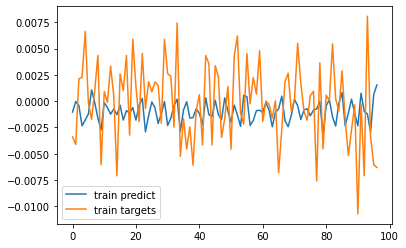

In [103]:
# fittingの確認
train_predict = model.predict(train_features)

start = 1000
plt.plot(train_predict[start:], label='train predict')
plt.plot(train_targets[start:, 0,0], label='train targets')
plt.legend()

model.evaluate(train_features, train_targets)
print(f'std: {np.std(train_predict-train_targets)/train_std}')

3/3 [==============================] - 0s 5ms/step - loss: 8.7336e-06


8.733620234124828e-06

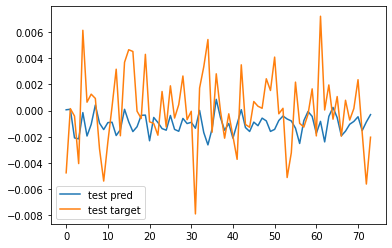

In [96]:
# 未来の予測
test_predict = model.predict(test_features)

plt.plot(test_predict, label='test pred')
plt.plot(test_targets[:,0,0], label='test target')
plt.legend()

model.evaluate(test_features, test_targets)

## 2021/01/10 観察
- 隠れ層のノード数は100以上にすると結果の振動が小さくなる?
- 評価方法はtrainのstdで正規化したrmseがいいかも